<a href="https://colab.research.google.com/github/MatCat960/pf-training/blob/main/15_rnn_coverage_dynamic_vel_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a Neural Network to perform distributed Coverage **with unknown number of robots**

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math

from pathlib import Path
from copy import deepcopy as dc

In [2]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {device}")

Using device: cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = Path("/content/drive/MyDrive/Colab Notebooks/PyTorch tutorial/dynamic_coverage_vel3").glob('**/*')
# path = Path("/content/drive/MyDrive/Colab Notebooks/PyTorch tutorial/dynamic_coverage_vel/log_6_robots.txt")
files = [x for x in path if x.is_file()]

In [5]:
len(files)

31

In [6]:
ROBOTS_NUM = 20
lookback = 7
AREA_W = 30.0
AREA_H = 30.0
GRID_STEPS = 64
ROBOT_RANGE = 15.0
ROBOT_FOV = 120.0

## Utility Functions

In [7]:
def in_fov(robot, target, fov, range):
  fov_rad = fov * math.pi / 180.0
  xr = robot[0]
  yr = robot[1]
  phi = robot[2]
  dx = target[0] - xr
  dy = target[1] - yr
  dist = math.sqrt(dx**2 + dy**2)
  if dist > range:
    return 0

  xrel = dx * math.cos(phi) + dy * math.sin(phi)
  yrel = -dy * math.sin(phi) + dy * math.cos(phi)
  angle = abs(math.atan2(yrel, xrel))
  if (angle <= fov_rad) and (xrel >= 0.0):
    return 1
  else:
    return 0

In [8]:
def gauss_pdf(x, y, means, covs):
  """
  Calculate the probability in the cell (x,y)

  Args:
    x (float) : x coord of the considered point
    y (float) : y coord of the considered point
    means (list(np.array)) : list of mean points
    covs (list(np.array)) : list of covariance matrices
  """

  prob = 0.0
  for i in range(len(means)):
    m = means[i]
    cov = covs[i]
    exp = -0.5 * np.sum

In [9]:
# X, Y : meshgrid
def multigauss_pdf(X, Y, means, sigmas):
  # Flatten the meshgrid coordinates
  points = np.column_stack([X.flatten(), Y.flatten()])

  # Number of components in the mixture model
  num_components = len(means)


  # Initialize the probabilities
  probabilities = np.zeros_like(X)

  # Calculate the probability for each component
  for i in range(num_components):
      mean = means[i]
      covariance = sigmas[i]

      # Calculate the multivariate Gaussian probability
      exponent = -0.5 * np.sum((points - mean) @ np.linalg.inv(covariance) * (points - mean), axis=1)
      coefficient = 1 / np.sqrt((2 * np.pi) ** 2 * np.linalg.det(covariance))
      component_prob = coefficient * np.exp(exponent)

      # Add the component probability weighted by its weight
      probabilities += component_prob.reshape(X.shape)

  return probabilities

In [10]:
def plot_fov(fov_deg, radius, ax):
  # fig = plt.figure(figsize=(6,6))
  # plt.scatter(neighs[:, 0], neighs[:, 1], marker='*')

  x1 = np.array([0.0, 0.0, 0.0])
  fov = fov_deg * math.pi / 180
  arc_theta = np.arange(-0.5*fov, 0.5*fov, 0.01*math.pi)
  th = np.arange(fov/2, 2*math.pi+fov/2, 0.01*math.pi)

  # FOV
  xfov = radius * np.cos(arc_theta)
  xfov = np.append(x1[0], xfov)
  xfov = np.append(xfov, x1[0])
  yfov = radius * np.sin(arc_theta)
  yfov = np.append(x1[1], yfov)
  yfov = np.append(yfov, x1[1])
  ax.plot(xfov, yfov)

In [11]:
def generate_sequence_tensor(original_tensor, sequence_length=5):
    num_samples, cols = original_tensor.shape
    sequence_tensor = torch.zeros(num_samples, sequence_length, cols)

    # sequence_tensor[:, 0, :, :, :] = original_tensor.roll(0, dims=0)
    for i in range(0, sequence_length):
        sequence_tensor[:, i, :] = original_tensor.roll(-i, dims=0)

    return sequence_tensor

In [12]:
from numpy import linalg as LA

def plot_ellipse(ctr, cov, ax, s=4.605):
  """
  Args:
    ctr (np.array(1, 2)): center of the ellipse
    cov (np.array(2, 2)): covariance matrix
    s (double): confidence interval
  """

  epsilon = 0.01

  eigenvalues, eigenvectors = LA.eigh(cov)
  eigenvalues = eigenvalues + epsilon
  # print(f"Eigenvalues: {eigenvalues}")
  # if eigenvalues[0] < 0.0 or eigenvalues[1] < 0.0:
  #   print(f"Cov matrix: {cov}")
  #   print(f"Eigenvalues: {eigenvalues}")
  # eigenvalues[eigenvalues < 0.0] = 0.1
  a = math.sqrt(s*abs(eigenvalues[0]))
  b = math.sqrt(s*abs(eigenvalues[1]))

  if (a < b):
    temp = dc(a)
    a = dc(b)
    b = temp

  print(f"Major axis: {a}")

  m = 0
  l = 1
  if eigenvalues[1] > eigenvalues[0]:
    m = 1
    l = 0

  theta = math.atan2(eigenvectors[1,m], eigenvectors[0,m])
  if theta < 0.0:
    theta += math.pi

  vx = []; vy = []
  x = ctr[0]
  y = ctr[1]
  for phi in np.arange(0, 2*np.pi, 0.1):
    xs = x + a * np.cos(phi) * np.cos(theta) - b * np.sin(phi) * np.sin(theta)
    ys = y + a * np.cos(phi) * np.sin(theta) + b * np.sin(phi) * np.cos(theta)
    vx.append(xs)
    vy.append(ys)

  vx.append(vx[0])
  vy.append(vy[0])

  # fig = plt.figure(figsize=(6,6))
  ax.plot(vx, vy)






In [13]:
# # data0 = []
# data = []
# sizes = []
# for file in files:
#   with open(file) as f:
#     lines = f.readlines()
#     sizes.append(len(lines))

#   data0 = []
#   write = False
#   for l in lines:
#     if not write and l[:5] != '100.0' and l[:5] != '99.90':
#       write = True

#     if write:
#       data0.append(l)

#   # print("Original length: {}".format(len(data0)))
#   s = int(len(data0)/ROBOTS_NUM) * ROBOTS_NUM
#   # print(f"Resized length: {s}")
#   for i in range(s):
#     data.append(data0[i])


# print(data[0])

# poses = np.zeros([len(data), 2], dtype="float32")

# for i in range(len(data)):
#   data[i] = data[i].replace('\n', '')
#   poses[i] = tuple(map(float, data[i].split(' ')))

In [14]:
data = []
sizes = []
for file in files:
  with open(file) as f:
    lines = f.readlines()
    sizes.append(len(lines))

  for l in lines:
    data.append(l)

print(data[0])

poses = np.zeros([len(data), 2], dtype="float32")

for i in range(len(data)):
  data[i] = data[i].replace('\n', '')
  poses[i] = tuple(map(float, data[i].split(' ')))


7.999984 7.000009



In [15]:
len(data)/ROBOTS_NUM

37958.0

## Split poses and velocities

In [16]:
pos = np.zeros((int(len(data)/2), 2), dtype="float32")
vel = np.zeros_like(pos)

print(poses[0])
print(f"Original length: {len(poses)}")
print(f"Pos length: {len(pos)}")

for i in range(0, len(pos)):
  pos[i] = poses[2*i]
  vel[i] = poses[2*i+1]



[7.999984 7.000009]
Original length: 759160
Pos length: 379580


In [17]:
pos[pos == 100.0] = 0.0
vel[vel == 99.9] = 0.0

In [18]:
pos[0]

array([7.999984, 7.000009], dtype=float32)

## Convert numpy to torch.Tensor

In [19]:
X = torch.from_numpy(pos).to(device)
y = torch.from_numpy(vel).to(device)

In [20]:
print(X[:ROBOTS_NUM, :])
X.shape, y.shape

tensor([[ 8.0000e+00,  7.0000e+00],
        [ 8.0000e+00, -9.9998e-01],
        [ 1.9000e-05, -1.0000e+00],
        [-4.0000e-06,  7.0000e+00],
        [-2.0000e+00,  3.0000e+00],
        [ 1.0000e+01,  3.0000e+00],
        [ 4.0000e+00,  9.0000e+00],
        [ 4.0000e+00, -3.0000e+00],
        [ 9.9998e-01, -3.0000e+00],
        [-2.0000e+00,  1.8000e-05],
        [ 4.5000e+00,  3.5000e+00],
        [ 2.0000e+00,  3.0000e+00],
        [-4.0000e+00,  3.0000e+00],
        [ 1.2000e+01,  3.0000e+00],
        [ 4.0000e+00,  1.1000e+01],
        [ 4.0000e+00, -5.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00]], device='cuda:0')


(torch.Size([379580, 2]), torch.Size([379580, 2]))

In [21]:
# X, y = X[:-4], y[:-4]
s = int(X.shape[0]/ROBOTS_NUM)

print(f"Original shape: {X.shape}")
X = X[:s*ROBOTS_NUM]
y = y[:s*ROBOTS_NUM]
print(f"Final shape: {X.shape}")

Original shape: torch.Size([379580, 2])
Final shape: torch.Size([379580, 2])


In [22]:
X = X.view(-1, 2*ROBOTS_NUM)
y = y.view(-1, 2*ROBOTS_NUM)

In [23]:
X.shape, y.shape

(torch.Size([18979, 40]), torch.Size([18979, 40]))

## Generate sequence tensor

In [24]:
Xseq = generate_sequence_tensor(X, lookback)
Xseq.shape

torch.Size([18979, 7, 40])

## Remove first `lookback` elements

In [25]:
Xseq = Xseq[lookback:, :, :]
y = y[lookback:, :]

X = Xseq.to(device)
X.shape, y.shape

(torch.Size([18972, 7, 40]), torch.Size([18972, 40]))

In [26]:
import random
rnd = random.randint(0, int(X.shape[0]/ROBOTS_NUM))
print(rnd)
X[rnd, :]

862


tensor([[ 2.6770,  2.2153,  2.9824, -2.1568, -0.5217, -1.1061, -1.7716,  3.0056,
         -2.9324,  0.7070,  3.6816,  0.0873,  0.6677,  2.7044,  1.0509, -2.7351,
         -1.1509, -3.5815, -2.9089, -1.6600,  1.3829, -0.0471, -0.4777,  0.8040,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 2.6712,  2.2149,  2.9756, -2.1599, -0.5272, -1.1059, -1.7775,  3.0056,
         -2.9365,  0.7048,  3.6765,  0.0857,  0.6617,  2.7056,  1.0438, -2.7351,
         -1.1555, -3.5820, -2.9134, -1.6604,  1.3771, -0.0477, -0.4772,  0.8040,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 2.6669,  2.2146,  2.9705, -2.1624, -0.5320, -1.1058, -1.7840,  3.0056,
         -2.9406,  0.7026,  3.6708,  0.0840,  0.6549,  2.7070,  1.0363, -2.7351,
         -1.1588, -3.5824,

## Create train and test split

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2)

y_train = y_train.squeeze(1)
y_test = y_test.squeeze(1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([15177, 7, 40]),
 torch.Size([3795, 7, 40]),
 torch.Size([15177, 40]),
 torch.Size([3795, 40]))

In [28]:
from torch.utils.data import TensorDataset, DataLoader

# create TensorDatasets for training and testing sets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [29]:
for input, target in train_loader:
  print(input.shape, target.shape)
  break

torch.Size([64, 7, 40]) torch.Size([64, 40])


## Define neural network model

In [30]:
class CoverageModel(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.input_size = input_size
    self.output_size = output_size

    self.fc1 = nn.Linear(input_size, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, output_size)
    self.relu = nn.ReLU(inplace=True)
    # self.activation = nn.Sigmoid()
    self.activation = nn.Tanh()

  def forward(self, x):
    x = self.activation(self.fc1(x))
    x = self.activation(self.fc2(x))
    x = self.fc3(x)

    return x

In [31]:
class DynamicCoverageModel(nn.Module):
  def __init__(self, max_size):
    super().__init__()
    self.max_size = max_size
    self.input_size = max_size
    self.output_size = max_size

    self.fc1 = nn.Linear(self.input_size, 64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, self.output_size)
    self.relu = nn.ReLU()
    self.activation = nn.Tanh()

  def reshape(self, x):
    (x == 100.0).nonzero(as_tuple=True)

    size = x.shape[1]
    self.input_size = size
    self.output_size = size

    self.fc1 = nn.Linear(self.input_size, 64)
    self.fc3 = nn.Linear(32, self.output_size)

  def forward(self, x):
    self.reshape(x)
    x = self.activation(self.fc1(x))
    x = self.activation(self.fc2(x))
    x = self.fc3(x)

    return x

In [32]:
class CoverageModel2(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.input_size = input_size
    self.output_size = output_size

    self.fc1 = nn.Linear(input_size, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 32)
    self.fc5 = nn.Linear(32, output_size)
    self.relu = nn.ReLU()
    # self.activation = nn.Sigmoid()
    self.activation = nn.Tanh()


  def forward(self, x):

    in_size = 0
    # print(x.shape)
    for i in range(x.shape[1]):
      # print(row.shape)
      if x[0, i] != 0.0:
        in_size += 1

    # print("x:")
    # print(x)
    # print("in_size: {}".format(in_size))

    x = self.activation(self.fc1(x))
    x = self.activation(self.fc2(x))
    x = self.activation(self.fc3(x))
    x = self.activation(self.fc4(x))
    x = self.fc5(x)

    out = np.zeros((x.shape[0], self.input_size), dtype="float32")
    out = torch.from_numpy(out).to(device)
    out[:, :in_size] = x[:, :in_size]

    # out = out.to(device)

    return out

In [ ]:
class DropoutCoverageModel(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.input_size = input_size
    self.output_size = output_size

    self.fc1 = nn.Linear(input_size, 128)
    self.dropout1 = nn.Dropout(0.2)
    self.fc2 = nn.Linear(128, 64)
    self.dropout2 = nn.Dropout(0.2)
    self.fc3 = nn.Linear(64, output_size)
    self.relu = nn.ReLU()
    # self.activation = nn.Sigmoid()
    self.activation1 = nn.Tanh()
    self.activation2 = nn.Tanh()


  def forward(self, x):

    in_size = 0
    # print(x.shape)
    for i in range(x.shape[1]):
      # print(row.shape)
      if x[0, i] != 0.0:
        in_size += 1

    # print("x:")
    # print(x)
    # print("in_size: {}".format(in_size))

    x = self.dropout1(self.activation1(self.fc1(x)))
    x = self.dropout2(self.activation2(self.fc2(x)))
    # x = self.activation(self.fc3(x))
    # x = self.activation(self.fc4(x))
    x = self.fc3(x)

    out = np.zeros((x.shape[0], self.input_size), dtype="float32")
    out = torch.from_numpy(out).to(device)
    out[:, :in_size] = x[:, :in_size]

    # out = out.to(device)

    return out

In [40]:
class CoverageRNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers, output_size):
    super().__init__()
    self.input_size = input_size
    self.output_size = output_size
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(hidden_size, hidden_size)
    self.dropout1 = nn.Dropout(0.2)
    self.fc2 = nn.Linear(hidden_size, 64)
    self.dropout2 = nn.Dropout(0.2)
    self.fc3 = nn.Linear(64, output_size)
    self.relu = nn.ReLU()
    # self.activation = nn.Sigmoid()
    self.activation1 = nn.Tanh()
    self.activation2 = nn.Tanh()


  def forward(self, x):
    in_size = 0
    # print(x.shape)
    for i in range(x.shape[2]):
      # print(row.shape)
      if x[0, 0, i] != 0.0:
        in_size += 1

    batch_size, seq_len, _ = x.size()
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

    x, _ = self.lstm(x, (h0, c0))
    # print(f"x Shape: {x[:, -1, :].shape}")
    x = self.dropout1(self.activation1(self.fc1(x[:, -1, :])))
    x = self.dropout2(self.activation2(self.fc2(x)))
    x = self.fc3(x)

    out = np.zeros((x.shape[0], self.input_size), dtype="float32")
    out = torch.from_numpy(out).to(device)
    out[:, :in_size] = x[:, :in_size]

    return out

## Training

In [41]:
model = CoverageRNN(input_size = 2 * ROBOTS_NUM,
                    output_size = 2 * ROBOTS_NUM,
                    hidden_size = 128,
                    num_stacked_layers= 4)
model = model.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

RUN_BATCHED = False

In [ ]:
X_train[0, :]

tensor([ 2.2644,  2.1435,  1.3859, -1.5658, -1.8251, -2.1595, -1.8479,  1.5646,
        -4.0460,  0.6479,  1.2033,  0.1869, -0.2448,  0.9954,  0.0686, -2.9873,
        -1.4722, -4.5687, -3.9426, -2.0408, -0.4278, -0.9466, -2.0957, -0.2749,
        -2.6773,  3.3814,  3.4266, -0.2820,  0.0772,  3.2800,  2.6078, -3.3643,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
       device='cuda:0')

## Train on unbatched data

In [ ]:
if RUN_BATCHED:
  epochs = 100
  for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
      outputs = model(inputs)
      if epoch == 0.0:
        print(f"Output shape: {outputs.shape}")
        print(f"Targets shape: {targets.shape}")

      loss = loss_fn(outputs, targets)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

    print(f"Epoch: {epoch+1} | Loss: {running_loss/len(train_loader)}")

    ### Testing
    model.eval()
    with torch.no_grad():
      running_test_loss = 0.0
      for test_inputs, test_targets in test_loader:
        test_outputs = model(test_inputs)
        test_loss = loss_fn(test_outputs, test_targets)
        running_test_loss += test_loss.item()

      print(f"Epoch: {epoch+1} | Test Loss: {running_test_loss/len(test_loader)}")

In [43]:
if not RUN_BATCHED:
  epochs = 1000
  epsilon = 0.01

  for epoch in range(epochs):
    model.train()
    y_pred = model(X_train)
    if epoch == 0:
      print(f"output shape: {y_pred.shape}")
      print(f"Target shape: {y_train.shape}")
    loss = loss_fn(y_pred, y_train)
    torch.autograd.set_detect_anomaly(True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
      test_pred = model(X_test)
      test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss.item()} | Test loss: {test_loss.item()}")

output shape: torch.Size([15177, 40])
Target shape: torch.Size([15177, 40])
Epoch: 0 | Loss: 0.008201242424547672 | Test loss: 0.0023626554757356644
Epoch: 100 | Loss: 0.008059612475335598 | Test loss: 0.0022275480441749096
Epoch: 200 | Loss: 0.008090215735137463 | Test loss: 0.002113889204338193
Epoch: 300 | Loss: 0.007903171703219414 | Test loss: 0.002004822250455618
Epoch: 400 | Loss: 0.00785759836435318 | Test loss: 0.0019064572406932712
Epoch: 500 | Loss: 0.0076882983557879925 | Test loss: 0.0018110517412424088
Epoch: 600 | Loss: 0.00762392720207572 | Test loss: 0.0018143533961847425
Epoch: 700 | Loss: 0.007574292365461588 | Test loss: 0.00174998480360955
Epoch: 800 | Loss: 0.007525595836341381 | Test loss: 0.0017100394470617175
Epoch: 900 | Loss: 0.007381242234259844 | Test loss: 0.00164163822773844


In [ ]:
# for name, param in model.named_parameters():
#   if param.requires_grad:
#     print(name, param)

## Test on simulated robots

array([[-11.572036 , -25.993267 ],
       [-32.244656 , -29.606537 ],
       [-21.143097 , -21.631744 ],
       [-25.518595 ,  -9.920757 ],
       [-10.458222 ,  -7.0388517],
       [ -3.176805 , -16.76211  ],
       [ -2.5452359,  -8.419876 ],
       [ -1.7714417, -29.70633  ],
       [-34.320885 , -19.817707 ],
       [-38.88714  ,  -2.7817547],
       [-37.667297 , -22.851624 ],
       [-29.67678  , -28.49182  ],
       [  0.       ,   0.       ],
       [  0.       ,   0.       ],
       [  0.       ,   0.       ],
       [  0.       ,   0.       ],
       [  0.       ,   0.       ],
       [  0.       ,   0.       ],
       [  0.       ,   0.       ],
       [  0.       ,   0.       ]], dtype=float32)

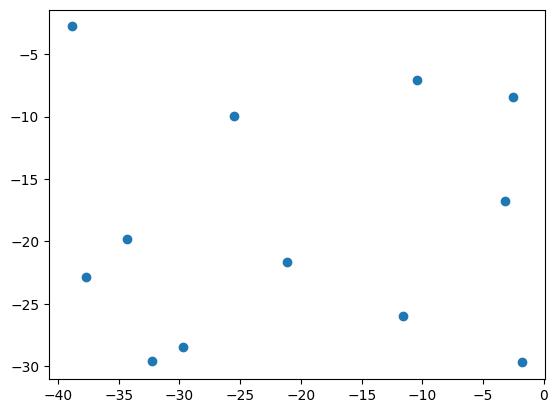

In [177]:
import random
N_ROBOTS = 12
robots = np.zeros((N_ROBOTS, 2), dtype="float32")
for i in range(N_ROBOTS):
  robots[i, :] = -40.0 + 40.0 * np.random.rand(1, 2)

robots_dummy = np.zeros((ROBOTS_NUM, 2), dtype="float32")
robots_dummy[:N_ROBOTS, :] = robots
# robots = np.array(([-4.0, 4.0],
#                   [-4.0, -4.0],
#                   [4.0, -4.0],
#                   [4.0, 4.0],
#                   [6.0, 0.0],
#                   [-6.0, 0.0]),
#                   dtype="float32")

# robots = robots - 8.0
plt.scatter(robots[:, 0], robots[:, 1])
Xt = torch.from_numpy(robots_dummy)
Xt = Xt.view(-1, ROBOTS_NUM*2)
Xt = Xt.to(device)

robots_dummy[:ROBOTS_NUM, :]

In [178]:
Xt[0, 0]

tensor(-11.5720, device='cuda:0')

## Simulate first steps

Simulate first `lookback` steps as a linear motion towards `(0,0)`.

In [179]:
Xt_seq = torch.zeros((1, lookback, 2*ROBOTS_NUM)).to(device)
print(f"Xt_seq shape: {Xt_seq.shape}")
Xt_seq[:, -1, :] = dc(Xt)
vmax = 1.0
# vel_tensor = torch.Tensor([vel, vel]).to(device)
K = 0.8
dt = 0.2
# j = 0
# xi = Xt[:, 2*j:2*(j+1)]
for i in range(lookback):
  x_n = torch.zeros((1, 2*ROBOTS_NUM)).to(device)
  xi = Xt_seq[:, lookback-i-1, :]
  # print(f"xi shape: {xi.shape}")
  # print(f"xn shape: {x_n.shape}")
  for j in range(ROBOTS_NUM):
    xj = xi[0, 2*j:2*(j+1)]
    # print(f"xj shape: {xj.shape}")
    dx = -K * xi[0, 2*j]
    dy = -K * xi[0, 2*j+1]
    vx = max(-vmax, min(vmax, dx))
    vy = max(-vmax, min(vmax, dy))
    x_n[0, 2*j] = xj[0] + dt * vx
    x_n[0, 2*j+1] = xj[1] + dt * vy
  # print(x_n)

  Xt_seq[:, lookback-i-2, :] = x_n


print(f"Final shape: {Xt_seq.shape}")





Xt_seq shape: torch.Size([1, 7, 40])
Final shape: torch.Size([1, 7, 40])


## Plot simulated steps

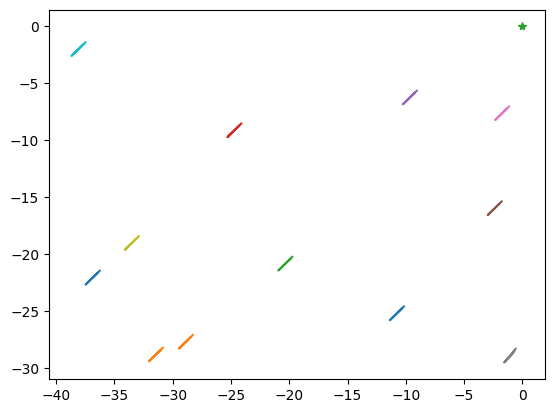

In [180]:
Xt_seq = Xt_seq.view((lookback, -1, 2*ROBOTS_NUM))
for i in range(N_ROBOTS):
  plt.plot(Xt_seq[:, 0, 2*i].cpu().detach().numpy(), Xt_seq[:, 0, 2*i+1].cpu().detach().numpy())

plt.plot(0.0, 0.0, '*')

## Forecast next steps

In [181]:
NUM_STEPS = 2000
dt = 0.2

X_hist = [Xt]
# v_hist = []

r_hist = []

In [182]:
Xt_seq = Xt_seq.view((-1, lookback, 2*ROBOTS_NUM))

for i in range(ROBOTS_NUM):
  r = []
  r_hist.append(r)

robots_hist = torch.Tensor(NUM_STEPS, ROBOTS_NUM, 2)
print(robots_hist.shape)

for i in range(NUM_STEPS):
  # get velocity
  v_pred = model(Xt_seq)
  if i % 100 == 0.0:
    print(f"Vpred : {v_pred}")

  # move robots
  # v = v_pred.view(ROBOTS_NUM, 2)

  # for j in range(2*ROBOTS_NUM):
  Xt_new = Xt_seq[0, 0, :] + v_pred[0, :] * dt
  Xt_new = Xt_new.unsqueeze(0)
  Xt_new = Xt_new.unsqueeze(0)
  # print(f"Xt-new shape: {Xt_new.shape}")
  Xt_seq = torch.cat((Xt_new, Xt_seq[:, :-1, :]), dim=1)
  # print(f"Actual Xt_seq shape: {Xt_seq.shape}")

  xp = Xt_new.view(ROBOTS_NUM, 2)
  for j in range(ROBOTS_NUM):
    robots_hist[i, j, :] = xp[j, :]

  # X_hist.append(Xt)





torch.Size([2000, 20, 2])
Vpred : tensor([[1.0838, 0.8294, 0.2850, 0.9544, 1.0524, 0.8559, 0.9397, 0.9993, 0.8832,
         0.8409, 0.5928, 0.9285, 0.9932, 0.6059, 0.7082, 0.8177, 0.9373, 0.7123,
         1.0482, 0.7377, 0.8703, 0.9341, 0.7761, 0.9940, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CopySlices>)
Vpred : tensor([[0.3149, 0.3374, 0.6577, 0.9359, 0.5826, 0.6351, 1.1613, 0.5832, 0.3044,
         0.5127, 0.4989, 0.4449, 0.6220, 0.2970, 0.6064, 1.0111, 0.7200, 0.1951,
         1.0788, 0.4182, 0.5870, 0.6178, 0.6180, 0.6018, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<CopySlices>)
Vpred : tensor([[-0.0093, -0.0670, -0.1672,  0.1663, -0.2426, -0.1059, -0.0049, -0.0823,
         -0.0431,  0.0141,  0.0519, -0.0149

In [183]:
robots_hist[:, 0, :]

tensor([[-10.1553, -24.6274],
        [ -9.9389, -24.4614],
        [ -9.7231, -24.2952],
        ...,
        [ 25.2953, -11.4816],
        [ 25.2903, -11.4936],
        [ 25.2852, -11.5054]], grad_fn=<SliceBackward0>)

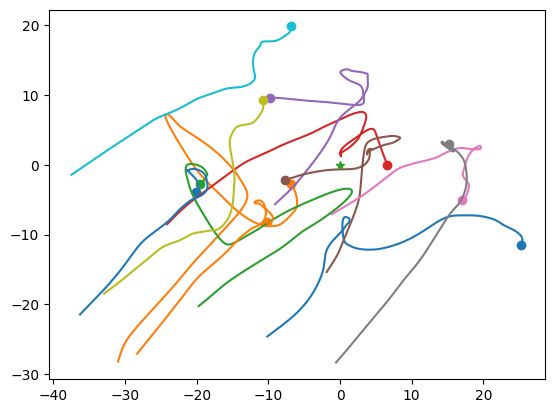

In [184]:
for i in range(N_ROBOTS):
  plt.plot(robots_hist[:, i, 0].cpu().detach().numpy(), robots_hist[:, i, 1].cpu().detach().numpy())

  # for i in range(ROBOTS_NUM):
  plt.scatter(robots_hist[-1, i, 0].cpu().detach().numpy(), robots_hist[-1, i, 1].cpu().detach().numpy())

plt.plot(0.0, 0.0, '*')

## Plot final position

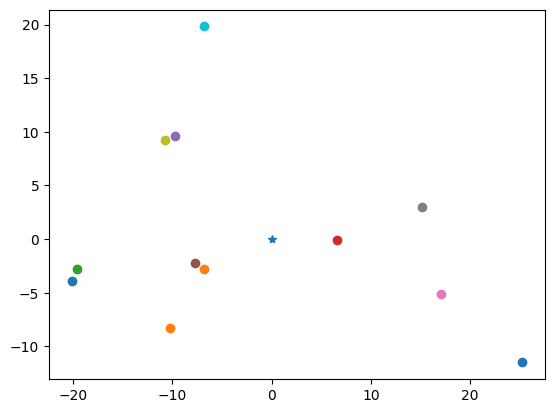

In [185]:
for i in range(N_ROBOTS):
  plt.scatter(robots_hist[-1, i, 0].cpu().detach().numpy(), robots_hist[-1, i, 1].cpu().detach().numpy())

plt.plot(0.0, 0.0, '*')